First, navigate to your chosen working directory.

In [1]:
%cd ~/..
%pwd

%matplotlib inline

/home


In [2]:
random_seed = 34
import random
random.seed(random_seed)
import dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from stuf import stuf

import tensorflow as tf;
tf.enable_eager_execution()

import leavesdb
from leavesdb.data_loaders.tensorpack_loaders import get_multiprocess_dataflow

/home/jacob/miniconda2/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacob/miniconda2/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacob/miniconda2/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jacob/miniconda2/envs/tf_gpu/lib/python3

#### **1.** Initialize and connect to database in local filesystem

In [3]:
local_db = leavesdb.init_local_db()

db = dataset.connect(f'sqlite:///{local_db}', row_type=stuf)

Proceeding with sql db at location /home/jacob/scripts/leavesdb.db


#### **2.** Print a summary of the database's contents

In [4]:
leavesdb.summarize_db(db)

Database column keys:
 ['id', 'specie', 'genus', 'path', 'family', 'dataset']
Number of distinct families:
 [('Fossil', 27), ('Leaves', 376), ('PNAS', 19), ('plant_village', 3)]
Number of rows in db:
 119084


#### **3.** Select a subset of datasets
##### Here we select the Fossil dataset

In [5]:
# data = leavesdb.db_query.load_Fossil_data(db)

data = leavesdb.db_query.load_Leaves_data(db)

#### **4.** Encode labels as integers for feeding into model

In [6]:
data_df = leavesdb.preprocessing.encode_labels(data)

data_df.sample(frac=1).head(10)

,family,path,label
7076,Saxifragaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,318
6576,Rutaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,307
6260,Rosaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,304
22526,Rhamnaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,301
26513,Theaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,350
3794,Juglandaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,185
3267,Fabaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,144
11587,Annonaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,21
5575,Polemoniaceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,289
10431,Schisandraceae,/media/data_cifs/sven2/leaves/sorted/Leaves_Da...,319


In [7]:
def get_class_counts(data_df, verbose=True):
    labels, label_counts = np.unique(data_df['label'], return_counts=True)
    if verbose:
        print('label : count')
        for label, count in zip(labels, label_counts):
            print(label,' : ', count)
    return labels, label_counts
    
def filter_low_count_labels(data_df, threshold=2, verbose = True):
    '''
    Function for omitting samples that belong to a class with a population size below the threshold. Used primarily for omitting classes with only 1 sample.
    '''
    labels, label_counts = np.unique(data_df['label'], return_counts=True)
    filtered_labels = np.where(label_counts >= threshold)[0]
    filtered_data = data_df[data_df['label'].isin(filtered_labels)]
    if verbose:
        print(f'Previous num_classes = {len(label_counts)}, new num_classes = {len(filtered_labels)}')
        print(f'Previous data_df.shape = {data_df.shape}, new data_df.shape = {filtered_data.shape}')
    return filtered_data

In [8]:
test_size = 0.25
val_size = 0.25

data_df = filter_low_count_labels(data_df, threshold=3, verbose = True)

train_data, test_data = train_test_split(data_df, test_size=test_size, random_state=random_seed, shuffle=True, stratify=data_df['label'])
train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=random_seed, shuffle=True, stratify=train_data['label'])

# train_gen = get_multiprocess_dataflow(train_data['path'], train_data['label'], size=(299,299), batch_size=32, num_prefetch=25, num_proc=5)

Previous num_classes = 376, new num_classes = 294
Previous data_df.shape = (26982, 3), new data_df.shape = (26869, 3)


## **Let's set up our model**

In [9]:
num_classes = len(np.unique(data_df['label']))
img_size = [299,299]
channels = 3
batch_size = 32
learning_rate=0.01
num_epochs = 1

def parse_function(filename, label):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=channels)#, dtype=tf.float32)
    img = tf.image.resize(img, img_size)
    return img, label #{'image':img, 'label':label}

# def train_preprocess(img, label):
#     img = tf.image.resize(img, img_size)
#     return {'image':img, 'label':label}
    

def get_tf_dataset(filenames, labels):
    data = tf.data.Dataset.from_tensor_slices((filenames, labels))
    data = data.shuffle(len(filenames))
    data = data.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     data = data.map(train_preprocess, num_parallel_calls=4)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
#     data = data.apply(tf.data.experimental.prefetch_to_device('/device:GPU:0'))
    return data

train_dataset = get_tf_dataset(filenames = train_data['path'].values, labels = train_data['label'].values)
val_dataset = get_tf_dataset(filenames = val_data['path'].values, labels = val_data['label'].values)


def decode_labels(data_df):
    data_df=data_df.groupby('label', group_keys=False).apply(lambda df: df.sample(1).loc[:,['label','family']])
    data_df.sort_values(by='label', inplace=True)
    data_df.set_index(keys='label',drop=True, inplace=True)
    data_df = data_df.to_dict()
    
    return data_df['family']



label_map = decode_labels(data_df=train_data)

In [10]:
label_map[0]

'Acanathaceae'

In [11]:
import time


num_samples_train = len(train_data)
num_samples_val = len(val_data)
num_samples_test = len(test_data)
print(num_samples_train)
print(num_samples_val)
print(num_samples_test)

15113
5038
6718


In [12]:
%matplotlib inline


# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(4,4, figsize=(15,15))
# axes = axes.flatten()

# imgs = features[0].numpy().astype(np.int)
# batch_labels = features[1].numpy().astype(np.int)

# for i, ax in enumerate(axes):
#     ax.imshow(imgs[i,...])
#     ax.set_title(batch_labels[i])

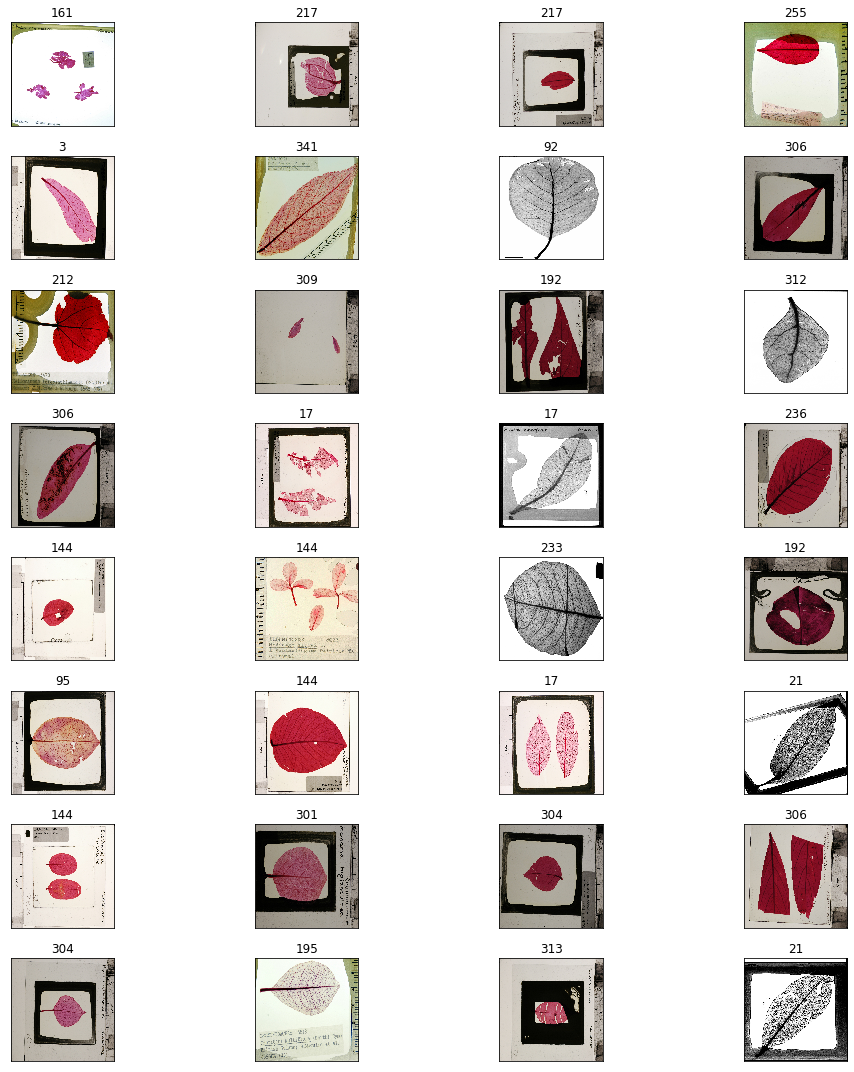

In [13]:
for features in  train_dataset.take(1):
    image_batch = features[0].numpy().astype(np.int)
    label_batch = features[1].numpy().astype(np.int)

leavesdb.img_utils.plot_image_grid(image_batch, label_batch, x_plots = 4, y_plots = 8)

In [14]:
start_time = time.time()
n=100
total_time = 0
try:
    for i, features in enumerate(train_dataset.take(n)):
#         print(i, features[0].shape, features[1].shape)
        run_time = time.time()-start_time
        total_time += run_time
        print(f'Took {run_time:.2f} seconds')
        start_time = time.time()
except Exception as e:
    print(e)
    print(f'finished {i} iterations')

avg_time = total_time / i+1

print(f'Avg time = {avg_time:.2f} | Ran {i+1} iterations using batch size = {batch_size} & {batch_size*n} samples')
    

Took 0.77 seconds
Took 0.60 seconds
Took 0.46 seconds
Took 0.58 seconds
Took 0.63 seconds
Took 0.32 seconds
Took 0.79 seconds
Took 0.19 seconds
Took 0.67 seconds
Took 0.43 seconds
Took 0.46 seconds
Took 0.53 seconds
Took 0.63 seconds
Took 0.39 seconds
Took 0.90 seconds
Took 0.18 seconds
Took 0.45 seconds
Took 0.69 seconds
Took 0.53 seconds
Took 0.37 seconds
Took 0.68 seconds
Took 0.38 seconds
Took 0.63 seconds
Took 0.45 seconds
Took 0.39 seconds
Took 0.53 seconds
Took 0.80 seconds
Took 0.23 seconds
Took 0.55 seconds
Took 0.43 seconds
Took 0.67 seconds
Took 0.37 seconds
Took 0.82 seconds
Took 0.32 seconds
Took 0.46 seconds
Took 0.65 seconds
Took 0.56 seconds
Took 0.36 seconds
Took 0.50 seconds
Took 0.60 seconds
Took 0.46 seconds
Took 0.66 seconds
Took 0.38 seconds
Took 0.45 seconds
Took 0.58 seconds
Took 0.52 seconds
Took 0.60 seconds
Took 0.56 seconds
Took 0.67 seconds
Took 0.44 seconds
Took 0.61 seconds
Took 0.60 seconds
Took 0.55 seconds
Took 0.49 seconds
Took 0.64 seconds
Took 0.33 

In [19]:
model = leavesdb.models.inception_v3.build_model(num_classes, learning_rate=learning_rate)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
history = leavesdb.models.inception_v3.train_model(model,
				train_dataset,
				validation_data=val_dataset, 
				steps_per_epoch=int(num_samples_train//batch_size),
				validation_steps=int(num_samples_val//batch_size),
				max_epochs=num_epochs,
# 				callbacks=None,
				workers=5,
				initial_epoch=0)

 78/472 [===>..........................] - ETA: 12:04 - loss: 436114.9547 - acc: 0.0124

InvalidArgumentError: Invalid JPEG data or crop window, data size 2427430
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNextSync]